# Plan real-world action using counterfactual example analysis and causal analysis

This notebooks is an adaptation of the [corresponding notebook in the `responsible-ai-toolbox` repository](https://github.com/microsoft/responsible-ai-toolbox/blob/main/notebooks/responsibleaidashboard/responsibleaidashboard-diabetes-decision-making.ipynb), modified to work with the Responsible AI components in AzureML.

We will use the Responsible AI components to assess a regression model trained on diabetes progression data. Next, we will walk through the API calls necessary to create a widget with model analysis insights, then undertake a visual analysis of the model.

First, we need to specify the version of the RAI components which are available in the workspace. This was specified when the components were uploaded, and will have defaulted to '1':

In [ ]:
version_string = "1"

We also need to give the name of the compute cluster we want to use in AzureML. Later in this notebook, we will create it if it does not already exist:

In [ ]:
compute_name = "rai-cluster"

Finally, we need to specify a version for the data and components we will create while running this notebook. This should be unique for the workspace, but the specific value doesn't matter:

In [ ]:
rai_diabetes_decision_making_example_version_string = "1"

## Configure workspace details and get a handle to the workspace

To connect to a workspace, we need identifier parameters - a subscription, resource group and workspace name. We will use these details in the MLClient from `azure.ai.ml` to get a handle to the required Azure Machine Learning workspace.

In [ ]:
# Enter details of your AML workspace
subscription_id = "<SUBSCRIPTION_ID>"
resource_group = "<RESOURCE_GROUP>"
workspace = "<AML_WORKSPACE_NAME>"

In [ ]:
# Handle to the workspace
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()
ml_client = MLClient(
    credential=credential,
    subscription_id=subscription_id,
    resource_group_name=resource_group,
    workspace_name=workspace,
)
print(ml_client)

In [ ]:
# Get handle to azureml registry for the RAI built in components
registry_name = "azureml"
ml_client_registry = MLClient(
    credential=credential,
    subscription_id=subscription_id,
    resource_group_name=resource_group,
    registry_name=registry_name,
)
print(ml_client_registry)

## Accessing the data

First, we need to obtain the dataset and upload it to our AzureML workspace:

In [ ]:
train_data_path = "data-diabetes-regression/train/"

In [ ]:
test_data_path = "data-diabetes-regression/test/"

Load some data for a quick view:

In [ ]:
import os
import pandas as pd
import mltable

tbl = mltable.load(train_data_path)
train_df: pd.DataFrame = tbl.to_pandas_dataframe()

# test dataset should have less than 5000 rows
test_df = mltable.load(test_data_path).to_pandas_dataframe()
assert len(test_df.index) <= 5000

display(train_df)

We are going to create two Datasets in AzureML, one for the train and one for the test datasets.

In [ ]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

input_train_data = "diabetes_decision_train_mltable"
input_test_data = "diabetes_decision_test_mltable"

try:
    # Try getting data already registered in workspace
    train_data = ml_client.data.get(
        name=input_train_data,
        version=rai_diabetes_decision_making_example_version_string,
    )
    test_data = ml_client.data.get(
        name=input_test_data,
        version=rai_diabetes_decision_making_example_version_string,
    )
except Exception as e:
    train_data = Data(
        path=train_data_path,
        type=AssetTypes.MLTABLE,
        description="RAI diabetes decision example training data",
        name=input_train_data,
        version=rai_diabetes_decision_making_example_version_string,
    )
    ml_client.data.create_or_update(train_data)

    test_data = Data(
        path=test_data_path,
        type=AssetTypes.MLTABLE,
        description="RAI diabetes decision example test data",
        name=input_test_data,
        version=rai_diabetes_decision_making_example_version_string,
    )
    ml_client.data.create_or_update(test_data)

## A model training pipeline

To simplify the model creation process, we're going to use a pipeline. This will have two stages:

1. The actual training component
1. A model registration component

We have to register the model in AzureML in order for our RAI insights components to use it.

### The Training Component

The training component is for this particular model. In this case, we are going to train a `RandomForestRegressor` on the input data and save it using MLFlow. We need command line arguments to specify the location of the input data, the location where MLFlow should write the output model, and the name of the target column in the dataset.

We start by creating a directory to hold the component source:

In [ ]:
import os

os.makedirs("component_src", exist_ok=True)
os.makedirs("register_model_src", exist_ok=True)

Next, put our training script into the directory:

In [ ]:
%%writefile component_src/diabetes_decision_training_script.py

import argparse
import os
import shutil
import tempfile


from azureml.core import Run

import mlflow
import mlflow.sklearn

import mltable

import pandas as pd
from sklearn.ensemble import RandomForestRegressor

def parse_args():
    # setup arg parser
    parser = argparse.ArgumentParser()

    # add arguments
    parser.add_argument("--training_data", type=str, help="Path to training data")
    parser.add_argument("--target_column_name", type=str, help="Name of target column")
    parser.add_argument("--model_output", type=str, help="Path of output model")

    # parse args
    args = parser.parse_args()

    # return args
    return args


def main(args):
    current_experiment = Run.get_context().experiment
    tracking_uri = current_experiment.workspace.get_mlflow_tracking_uri()
    print("tracking_uri: {0}".format(tracking_uri))
    mlflow.set_tracking_uri(tracking_uri)
    mlflow.set_experiment(current_experiment.name)

    # Read in data
    print("Reading data")
    tbl = mltable.load(args.training_data)
    all_data = tbl.to_pandas_dataframe()

    print("Extracting X_train, y_train")
    print("all_data cols: {0}".format(all_data.columns))
    y_train = all_data[args.target_column_name]
    X_train = all_data.drop(labels=args.target_column_name, axis="columns")
    print("X_train cols: {0}".format(X_train.columns))

    print("Training model")
    # The estimator can be changed to suit
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Saving model with mlflow - leave this section unchanged
    with tempfile.TemporaryDirectory() as td:
        print("Saving model with MLFlow to temporary directory")
        tmp_output_dir = os.path.join(td, "my_model_dir")
        mlflow.sklearn.save_model(sk_model=model, path=tmp_output_dir)

        print("Copying MLFlow model to output path")
        for file_name in os.listdir(tmp_output_dir):
            print("  Copying: ", file_name)
            # As of Python 3.8, copytree will acquire dirs_exist_ok as
            # an option, removing the need for listdir
            shutil.copy2(src=os.path.join(tmp_output_dir, file_name), dst=os.path.join(args.model_output, file_name))


# run script
if __name__ == "__main__":
    # add space in logs
    print("*" * 60)
    print("\n\n")

    # parse args
    args = parse_args()

    # run main function
    main(args)

    # add space in logs
    print("*" * 60)
    print("\n\n")

In [ ]:
%%writefile register_model_src/register.py

# ---------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# ---------------------------------------------------------

import argparse
import json
import os
import time


from azureml.core import Run

import mlflow
import mlflow.sklearn

# Based on example:
# https://docs.microsoft.com/en-us/azure/machine-learning/how-to-train-cli
# which references
# https://github.com/Azure/azureml-examples/tree/main/cli/jobs/train/lightgbm/iris


def parse_args():
    # setup arg parser
    parser = argparse.ArgumentParser()

    # add arguments
    parser.add_argument("--model_input_path", type=str, help="Path to input model")
    parser.add_argument(
        "--model_info_output_path", type=str, help="Path to write model info JSON"
    )
    parser.add_argument(
        "--model_base_name", type=str, help="Name of the registered model"
    )
    parser.add_argument(
        "--model_name_suffix", type=int, help="Set negative to use epoch_secs"
    )

    # parse args
    args = parser.parse_args()

    # return args
    return args


def main(args):
    current_experiment = Run.get_context().experiment
    tracking_uri = current_experiment.workspace.get_mlflow_tracking_uri()
    print("tracking_uri: {0}".format(tracking_uri))
    mlflow.set_tracking_uri(tracking_uri)
    mlflow.set_experiment(current_experiment.name)

    print("Loading model")
    mlflow_model = mlflow.sklearn.load_model(args.model_input_path)

    if args.model_name_suffix < 0:
        suffix = int(time.time())
    else:
        suffix = args.model_name_suffix
    registered_name = "{0}_{1}".format(args.model_base_name, suffix)
    print(f"Registering model as {registered_name}")

    print("Registering via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=mlflow_model,
        registered_model_name=registered_name,
        artifact_path=registered_name,
    )

    print("Writing JSON")
    dict = {"id": "{0}:1".format(registered_name)}
    output_path = os.path.join(args.model_info_output_path, "model_info.json")
    with open(output_path, "w") as of:
        json.dump(dict, fp=of)


# run script
if __name__ == "__main__":
    # add space in logs
    print("*" * 60)
    print("\n\n")

    # parse args
    args = parse_args()

    # run main function
    main(args)

    # add space in logs
    print("*" * 60)
    print("\n\n")


Now that the training script is saved on our local drive, we create a YAML file to describe it as a component to AzureML. This involves defining the inputs and outputs, specifing the AzureML environment which can run the script, and telling AzureML how to invoke the training script:

In [ ]:
from azure.ai.ml import load_component

yaml_contents = (
    f"""
$schema: http://azureml/sdk-2-0/CommandComponent.json
name: rai_diabetes_decision_training_component
display_name: Diabetes decision training component for RAI example
version: {rai_diabetes_decision_making_example_version_string}
type: command
inputs:
  training_data:
    type: path
  target_column_name:
    type: string
outputs:
  model_output:
    type: path
code: ./component_src/
environment: azureml://registries/azureml/environments/AzureML-responsibleai-0.20-ubuntu20.04-py38-cpu/versions/4
"""
    + r"""
command: >-
  python diabetes_decision_training_script.py
  --training_data ${{{{inputs.training_data}}}}
  --target_column_name ${{{{inputs.target_column_name}}}}
  --model_output ${{{{outputs.model_output}}}}
"""
)

yaml_filename = "RAIDiabetesDecisionTrainingComponent.yaml"

with open(yaml_filename, "w") as f:
    f.write(yaml_contents.format(yaml_contents))

train_model_component = load_component(source=yaml_filename)

In [ ]:
yaml_contents = f"""
$schema: http://azureml/sdk-2-0/CommandComponent.json
name: register_model
display_name: Register Model
version: {rai_diabetes_decision_making_example_version_string}
type: command
is_deterministic: False
inputs:
  model_input_path:
    type: path
  model_base_name:
    type: string
  model_name_suffix: # Set negative to use epoch_secs
    type: integer
    default: -1
outputs:
  model_info_output_path:
    type: path
code: ./register_model_src/
environment: azureml://registries/azureml/environments/AzureML-responsibleai-0.20-ubuntu20.04-py38-cpu/versions/4
command: >-
  python register.py
  --model_input_path ${{{{inputs.model_input_path}}}}
  --model_base_name ${{{{inputs.model_base_name}}}}
  --model_name_suffix ${{{{inputs.model_name_suffix}}}}
  --model_info_output_path ${{{{outputs.model_info_output_path}}}}

"""

yaml_filename = "register.yaml"

with open(yaml_filename, "w") as f:
    f.write(yaml_contents)

register_component = load_component(source=yaml_filename)

### Running a training pipeline

The component to register the model is part of the suite of RAI components, so we do not have to define it here. As such, we are now ready to run the training pipeline itself.

We start by ensuring that the compute cluster named above exists:

In [ ]:
from azure.ai.ml.entities import AmlCompute

all_compute_names = [x.name for x in ml_client.compute.list()]

if compute_name in all_compute_names:
    print(f"Found existing compute: {compute_name}")
else:
    my_compute = AmlCompute(
        name=compute_name,
        size="Standard_D2_v2",
        min_instances=0,
        max_instances=4,
        idle_time_before_scale_down=3600,
    )
    ml_client.compute.begin_create_or_update(my_compute)
    print("Initiated compute creation")

We continue by defining the name under which we want to register the model:

In [ ]:
import time

model_name_suffix = int(time.time())
model_name = "rai_diabetes_decision_model"

Next, we define the pipeline using objects from the AzureML SDKv2. As mentioned above, there are two component jobs: one to train the model, and one to register it:

In [ ]:
from azure.ai.ml import dsl, Input

target_feature = "y"

diabetes_train_pq = Input(
    type="mltable",
    path=f"azureml:{input_train_data}:{rai_diabetes_decision_making_example_version_string}",
    mode="download",
)
diabetes_test_pq = Input(
    type="mltable",
    path=f"azureml:{input_test_data}:{rai_diabetes_decision_making_example_version_string}",
    mode="download",
)


@dsl.pipeline(
    compute=compute_name,
    description="Register Model for RAI Diabetes Decision Making example",
    experiment_name=f"RAI_Diabetes_Decision_Example_Model_Training_{model_name_suffix}",
)
def my_training_pipeline(target_column_name, training_data):
    trained_model = train_model_component(
        target_column_name=target_column_name, training_data=training_data
    )
    trained_model.set_limits(timeout=120)

    _ = register_component(
        model_input_path=trained_model.outputs.model_output,
        model_base_name=model_name,
        model_name_suffix=model_name_suffix,
    )

    return {}


model_registration_pipeline_job = my_training_pipeline(
    target_feature, diabetes_train_pq
)

With the pipeline definition created, we can submit it to AzureML. We define a helper function to do the submission, which waits for the submitted job to complete:

In [ ]:
from azure.ai.ml.entities import PipelineJob
from IPython.core.display import HTML
from IPython.display import display


def submit_and_wait(ml_client, pipeline_job) -> PipelineJob:
    created_job = ml_client.jobs.create_or_update(pipeline_job)
    assert created_job is not None

    print("Pipeline job can be accessed in the following URL:")
    display(HTML('<a href="{0}">{0}</a>'.format(created_job.studio_url)))

    while created_job.status not in [
        "Completed",
        "Failed",
        "Canceled",
        "NotResponding",
    ]:
        time.sleep(30)
        created_job = ml_client.jobs.get(created_job.name)
        print("Latest status : {0}".format(created_job.status))
    assert created_job.status == "Completed"
    return created_job


# This is the actual submission
training_job = submit_and_wait(ml_client, model_registration_pipeline_job)

##  Creating the RAI Insights

We have a registered model, and can now run a pipeline to create the RAI insights. First off, compute the name of the model we registered:

In [ ]:
expected_model_id = f"{model_name}_{model_name_suffix}:1"
azureml_model_id = f"azureml:{expected_model_id}"

Now, we create the RAI pipeline itself. There are four 'component stages' in this pipeline:

1. Construct an empty `RAIInsights` object
1. Run the RAI tool components
1. Gather the tool outputs into a single `RAIInsights` object
1. (Optional) Generate a score card in pdf format summarizing model performance, and key aspects from the rai tool components

We start by loading the RAI component definitions for use in our pipeline:

In [ ]:
label = "latest"

rai_constructor_component = ml_client_registry.components.get(
    name="microsoft_azureml_rai_tabular_insight_constructor", label=label
)

# We get latest version and use the same version for all components
version = rai_constructor_component.version
print("The current version of RAI built-in components is: " + version)

rai_causal_component = ml_client_registry.components.get(
    name="microsoft_azureml_rai_tabular_causal", version=version
)

rai_counterfactual_component = ml_client_registry.components.get(
    name="microsoft_azureml_rai_tabular_counterfactual", version=version
)

rai_gather_component = ml_client_registry.components.get(
    name="microsoft_azureml_rai_tabular_insight_gather", version=version
)

rai_scorecard_component = ml_client_registry.components.get(
    name="microsoft_azureml_rai_tabular_score_card", version=version
)

## Score card generation config
For score card generation, we need some additional configuration in a separate json file. Here we configure the following model performance metrics for reporting:
- mean absolute error
- mean squared error

In [ ]:
import json

score_card_config_dict = {
    "Model": {
        "ModelName": "Diabetes disease progression measure",
        "ModelType": "Regression",
        "ModelSummary": "This model provides a quantitative measure of disease progression one year after baseline",
    },
    "Metrics": {"mean_absolute_error": {"threshold": "<=5"}, "mean_squared_error": {}},
}

score_card_config_filename = "rai_diabetes_decision_score_card_config.json"

with open(score_card_config_filename, "w") as f:
    json.dump(score_card_config_dict, f)

Now the pipeline itself. This creates an empty `RAIInsights` object, adds the analyses, and then gathers everything into the final `RAIInsights` output. Where complex objects need to be passed (such as a list of treatment feature names), they must be encoded as JSON strings.

Note that the timeout for the counterfactual generation is longer, since this is a comparatively slow process.

In [ ]:
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes

score_card_config_path = Input(
    type="uri_file", path=score_card_config_filename, mode="download"
)

treatment_feature_names = json.dumps(["bmi", "bp", "s2"])
desired_range = json.dumps([50, 120])


@dsl.pipeline(
    compute=compute_name,
    description="Example RAI computation on diabetes decision making data",
    experiment_name=f"RAI_Diabetes_Decision_Example_RAIInsights_Computation_{model_name_suffix}",
)
def rai_decision_pipeline(
    target_column_name, train_data, test_data, score_card_config_path
):
    # Initiate the RAIInsights
    create_rai_job = rai_constructor_component(
        title="RAI Dashboard Example",
        task_type="regression",
        model_info=expected_model_id,
        model_input=Input(type=AssetTypes.MLFLOW_MODEL, path=azureml_model_id),
        train_dataset=train_data,
        test_dataset=test_data,
        target_column_name=target_column_name,
    )
    create_rai_job.set_limits(timeout=120)

    # Add causal analysis
    causal_job = rai_causal_component(
        rai_insights_dashboard=create_rai_job.outputs.rai_insights_dashboard,
        treatment_features=treatment_feature_names,
    )
    causal_job.set_limits(timeout=120)

    # Add counterfactual analysis
    counterfactual_job = rai_counterfactual_component(
        rai_insights_dashboard=create_rai_job.outputs.rai_insights_dashboard,
        total_cfs=20,
        desired_range=desired_range,
    )
    counterfactual_job.set_limits(timeout=600)

    # Combine everything
    rai_gather_job = rai_gather_component(
        constructor=create_rai_job.outputs.rai_insights_dashboard,
        insight_2=causal_job.outputs.causal,
        insight_3=counterfactual_job.outputs.counterfactual,
    )
    rai_gather_job.set_limits(timeout=120)

    rai_gather_job.outputs.dashboard.mode = "upload"
    rai_gather_job.outputs.ux_json.mode = "upload"

    # Generate score card in pdf format for a summary report on model performance,
    # and observe distrbution of error between prediction vs ground truth.
    rai_scorecard_job = rai_scorecard_component(
        dashboard=rai_gather_job.outputs.dashboard,
        pdf_generation_config=score_card_config_path,
    )

    return {
        "dashboard": rai_gather_job.outputs.dashboard,
        "ux_json": rai_gather_job.outputs.ux_json,
        "scorecard": rai_scorecard_job.outputs.scorecard,
    }

Next, we define the pipeline object itself, and ensure that the outputs will be available for download:

In [ ]:
import uuid
from azure.ai.ml import Output

# Pipeline to construct the RAI Insights
insights_pipeline_job = rai_decision_pipeline(
    target_column_name=target_feature,
    train_data=diabetes_train_pq,
    test_data=diabetes_test_pq,
    score_card_config_path=score_card_config_path,
)

# Workaround to enable the download
rand_path = str(uuid.uuid4())
insights_pipeline_job.outputs.dashboard = Output(
    path=f"azureml://datastores/workspaceblobstore/paths/{rand_path}/dashboard/",
    mode="upload",
    type="uri_folder",
)
insights_pipeline_job.outputs.ux_json = Output(
    path=f"azureml://datastores/workspaceblobstore/paths/{rand_path}/ux_json/",
    mode="upload",
    type="uri_folder",
)
insights_pipeline_job.outputs.scorecard = Output(
    path=f"azureml://datastores/workspaceblobstore/paths/{rand_path}/scorecard/",
    mode="upload",
    type="uri_folder",
)

And submit the pipeline to AzureML for execution:

In [ ]:
insights_job = submit_and_wait(ml_client, insights_pipeline_job)

The dashboard should appear in the AzureML portal in the registered model view. The following cell computes the expected URI:

In [ ]:
sub_id = ml_client._operation_scope.subscription_id
rg_name = ml_client._operation_scope.resource_group_name
ws_name = ml_client.workspace_name

expected_uri = f"https://ml.azure.com/model/{expected_model_id}/model_analysis?wsid=/subscriptions/{sub_id}/resourcegroups/{rg_name}/workspaces/{ws_name}"

print(f"Please visit {expected_uri} to see your analysis")

Following the link should bring you to a page which looks similar to:
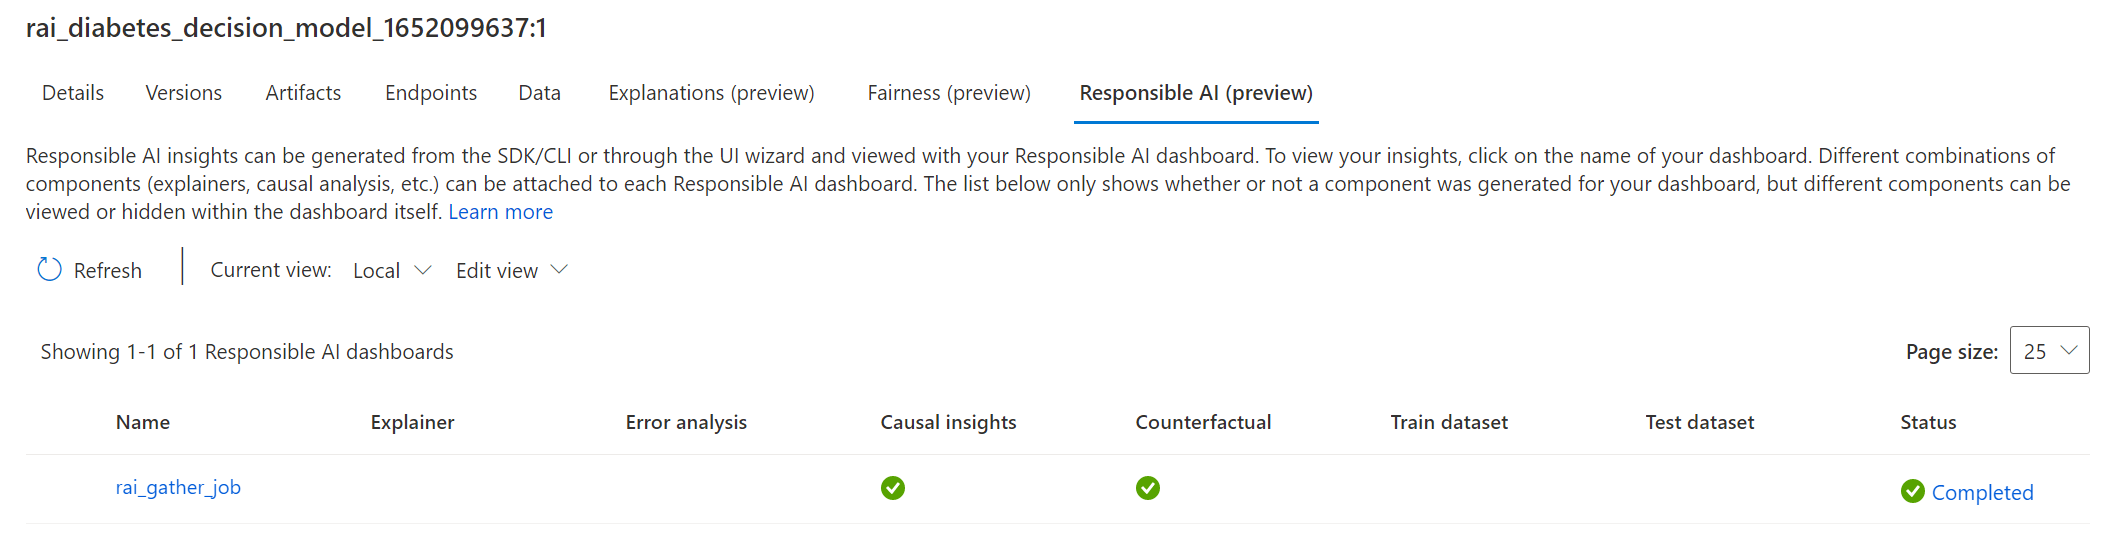

This page lists all of the RAI dashboards computed for this model. To view one, click on the appropriate entry in the 'Name' column.

## Downloading the Scorecard PDF

We can download the scorecard PDF from our pipeline as follows:

In [ ]:
target_directory = "."

ml_client.jobs.download(
    insights_job.name, download_path=target_directory, output_name="scorecard"
)

## Take Real-World Action

### What-If Counterfactuals Analysis

Let's imagine that the diabetes progression scores predicted by the model are used to determine medical insurance rates (note that how to perform an analysis will change based on the real-world scenario under consideration). Suppose that if the score is greater than 120, there is a higher rate. Patient 43's model score of 271.1 (note that this can vary slightly due to random number generation) results in this increased rate, and they want to know how they should change their health to get a lower rate prediction from the model (leading to lower insurance price).

The What-If counterfactuals component shows how slightly different feature values affect model predictions. This can be used to solve Patient 43's problem.

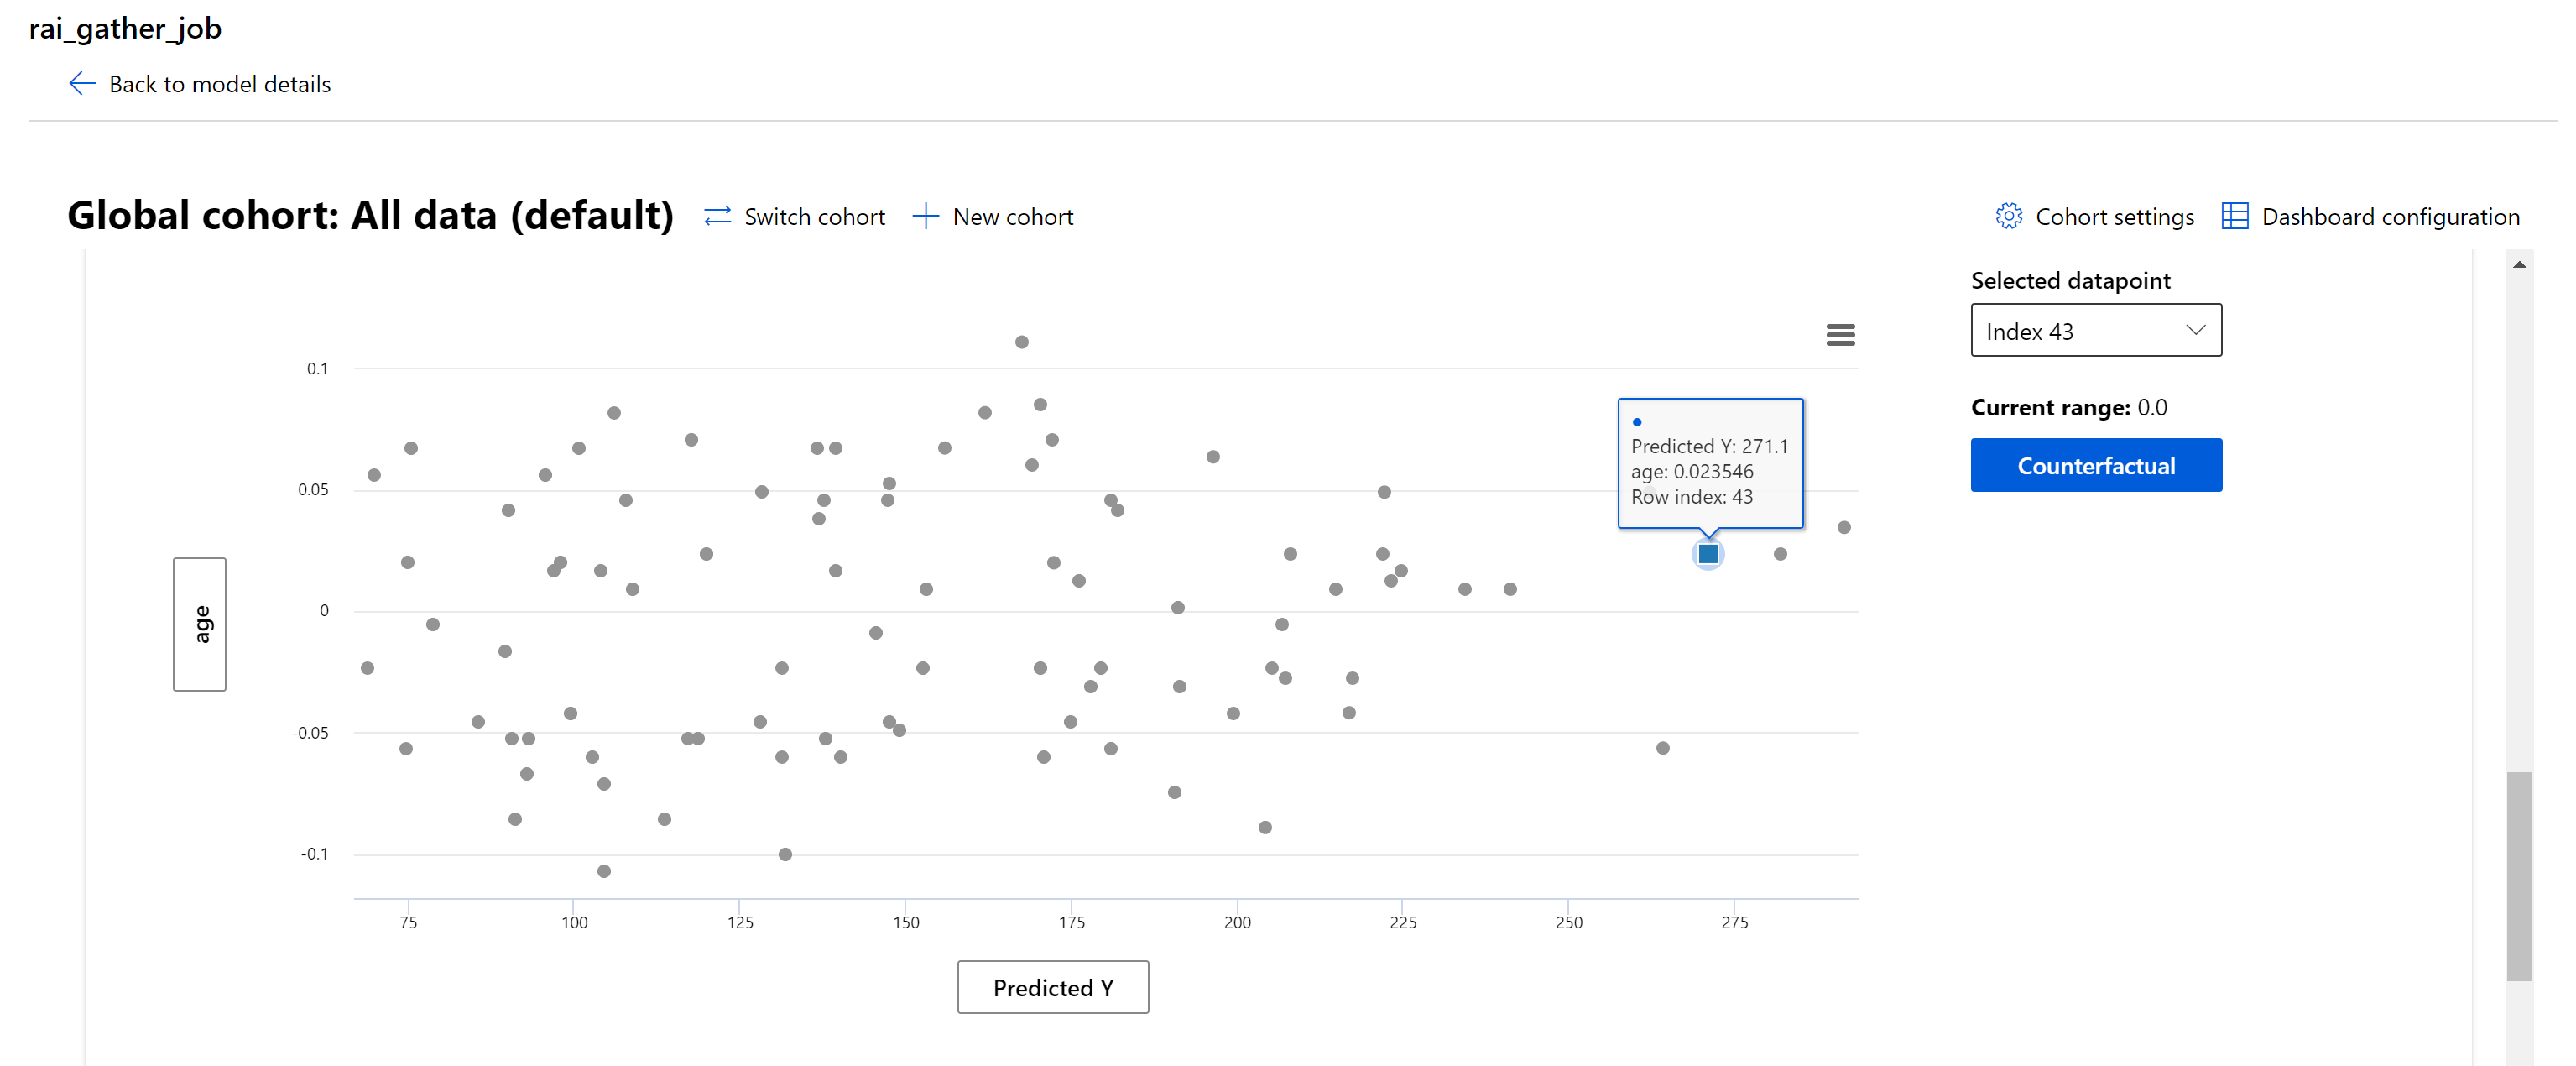

What can Patient 43 do to create the desired change? The top ranked features bar plot shows that `bmi` and `s5` are the best to perturb to bring the model score within 120:

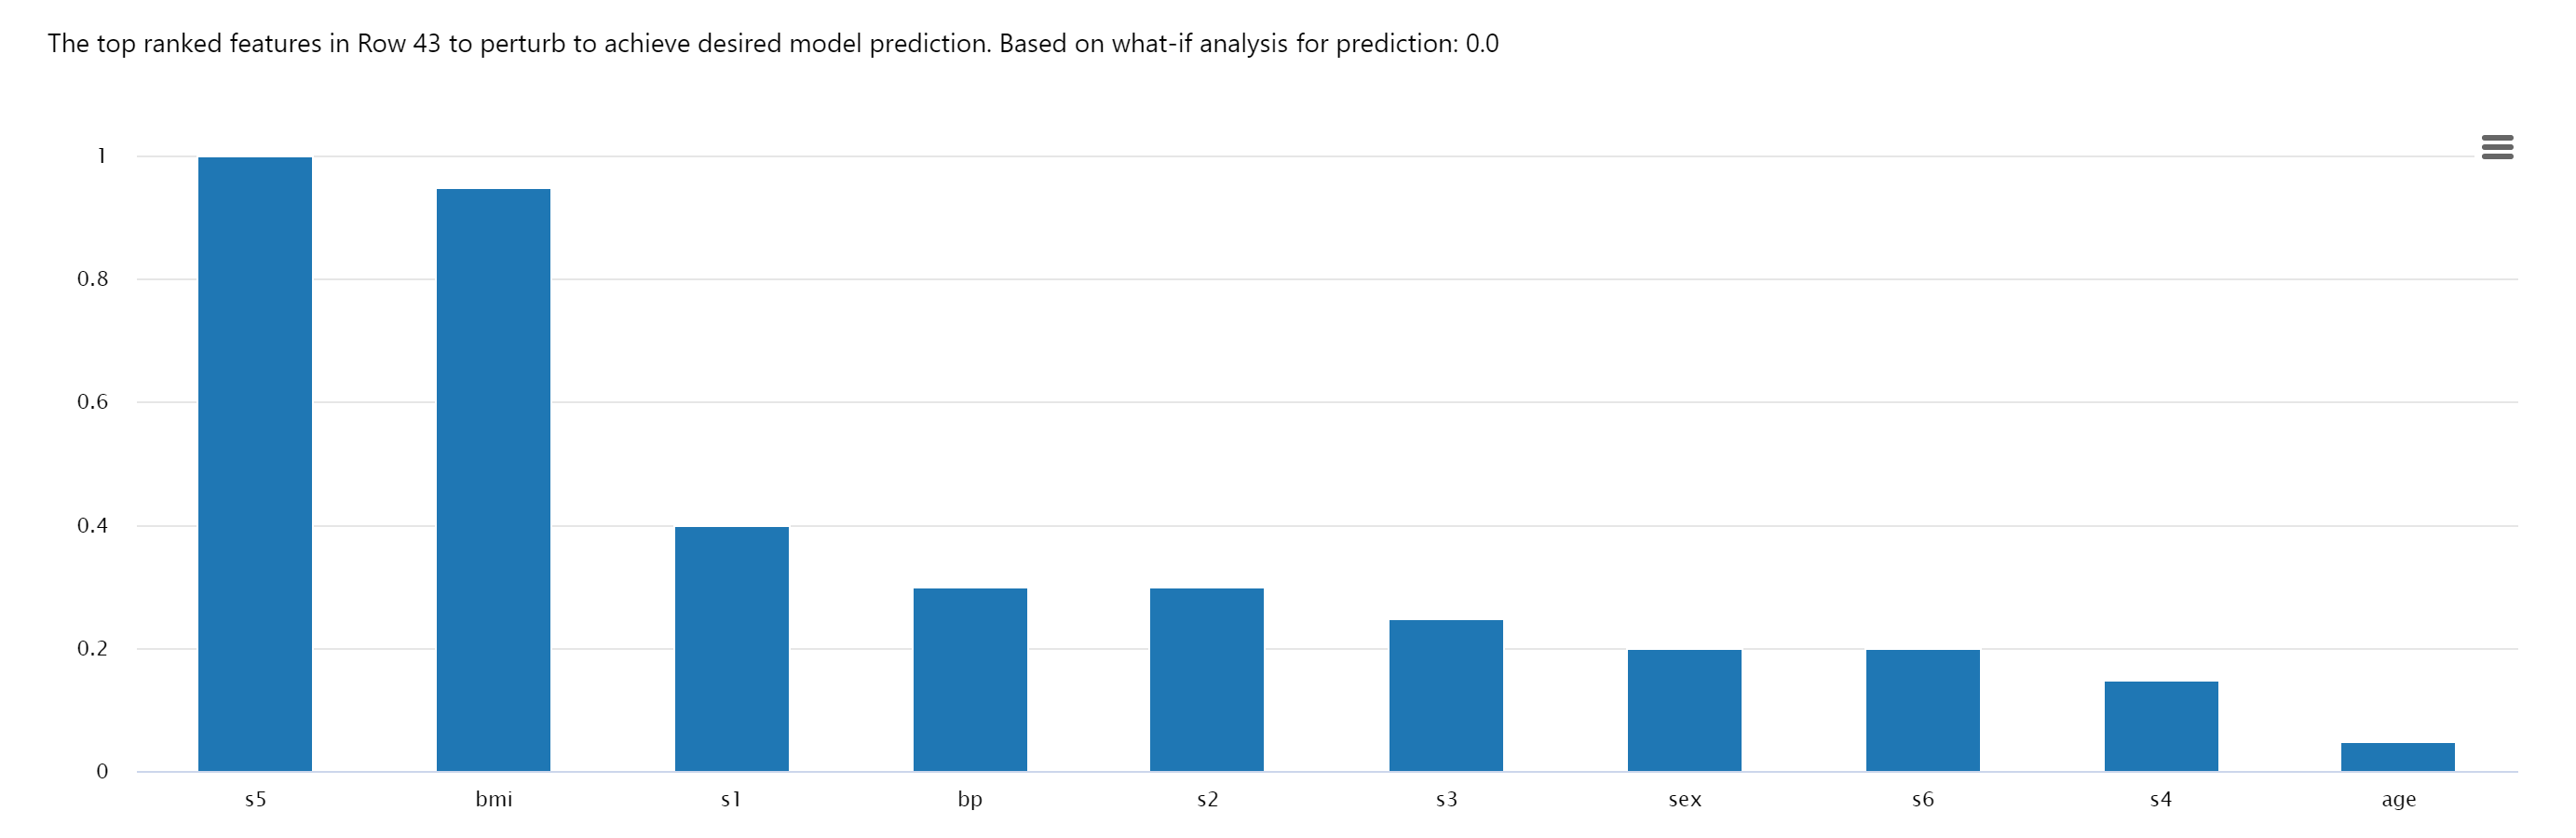

### Causal Analysis

Now suppose that a doctor wishes to know how to reduce the progression of diabetes in her patients. This can be explored in the Causal Inference component of the Responsible AI Toolbox.

In the "Aggregate causal effects" tab, it is possible to see how perturbing features causes lower disease progression. It appears that increasing s2 (LDL) by one unit, would increase diabetes progression by around 684 units (again, exact values can vary due to random number effects):

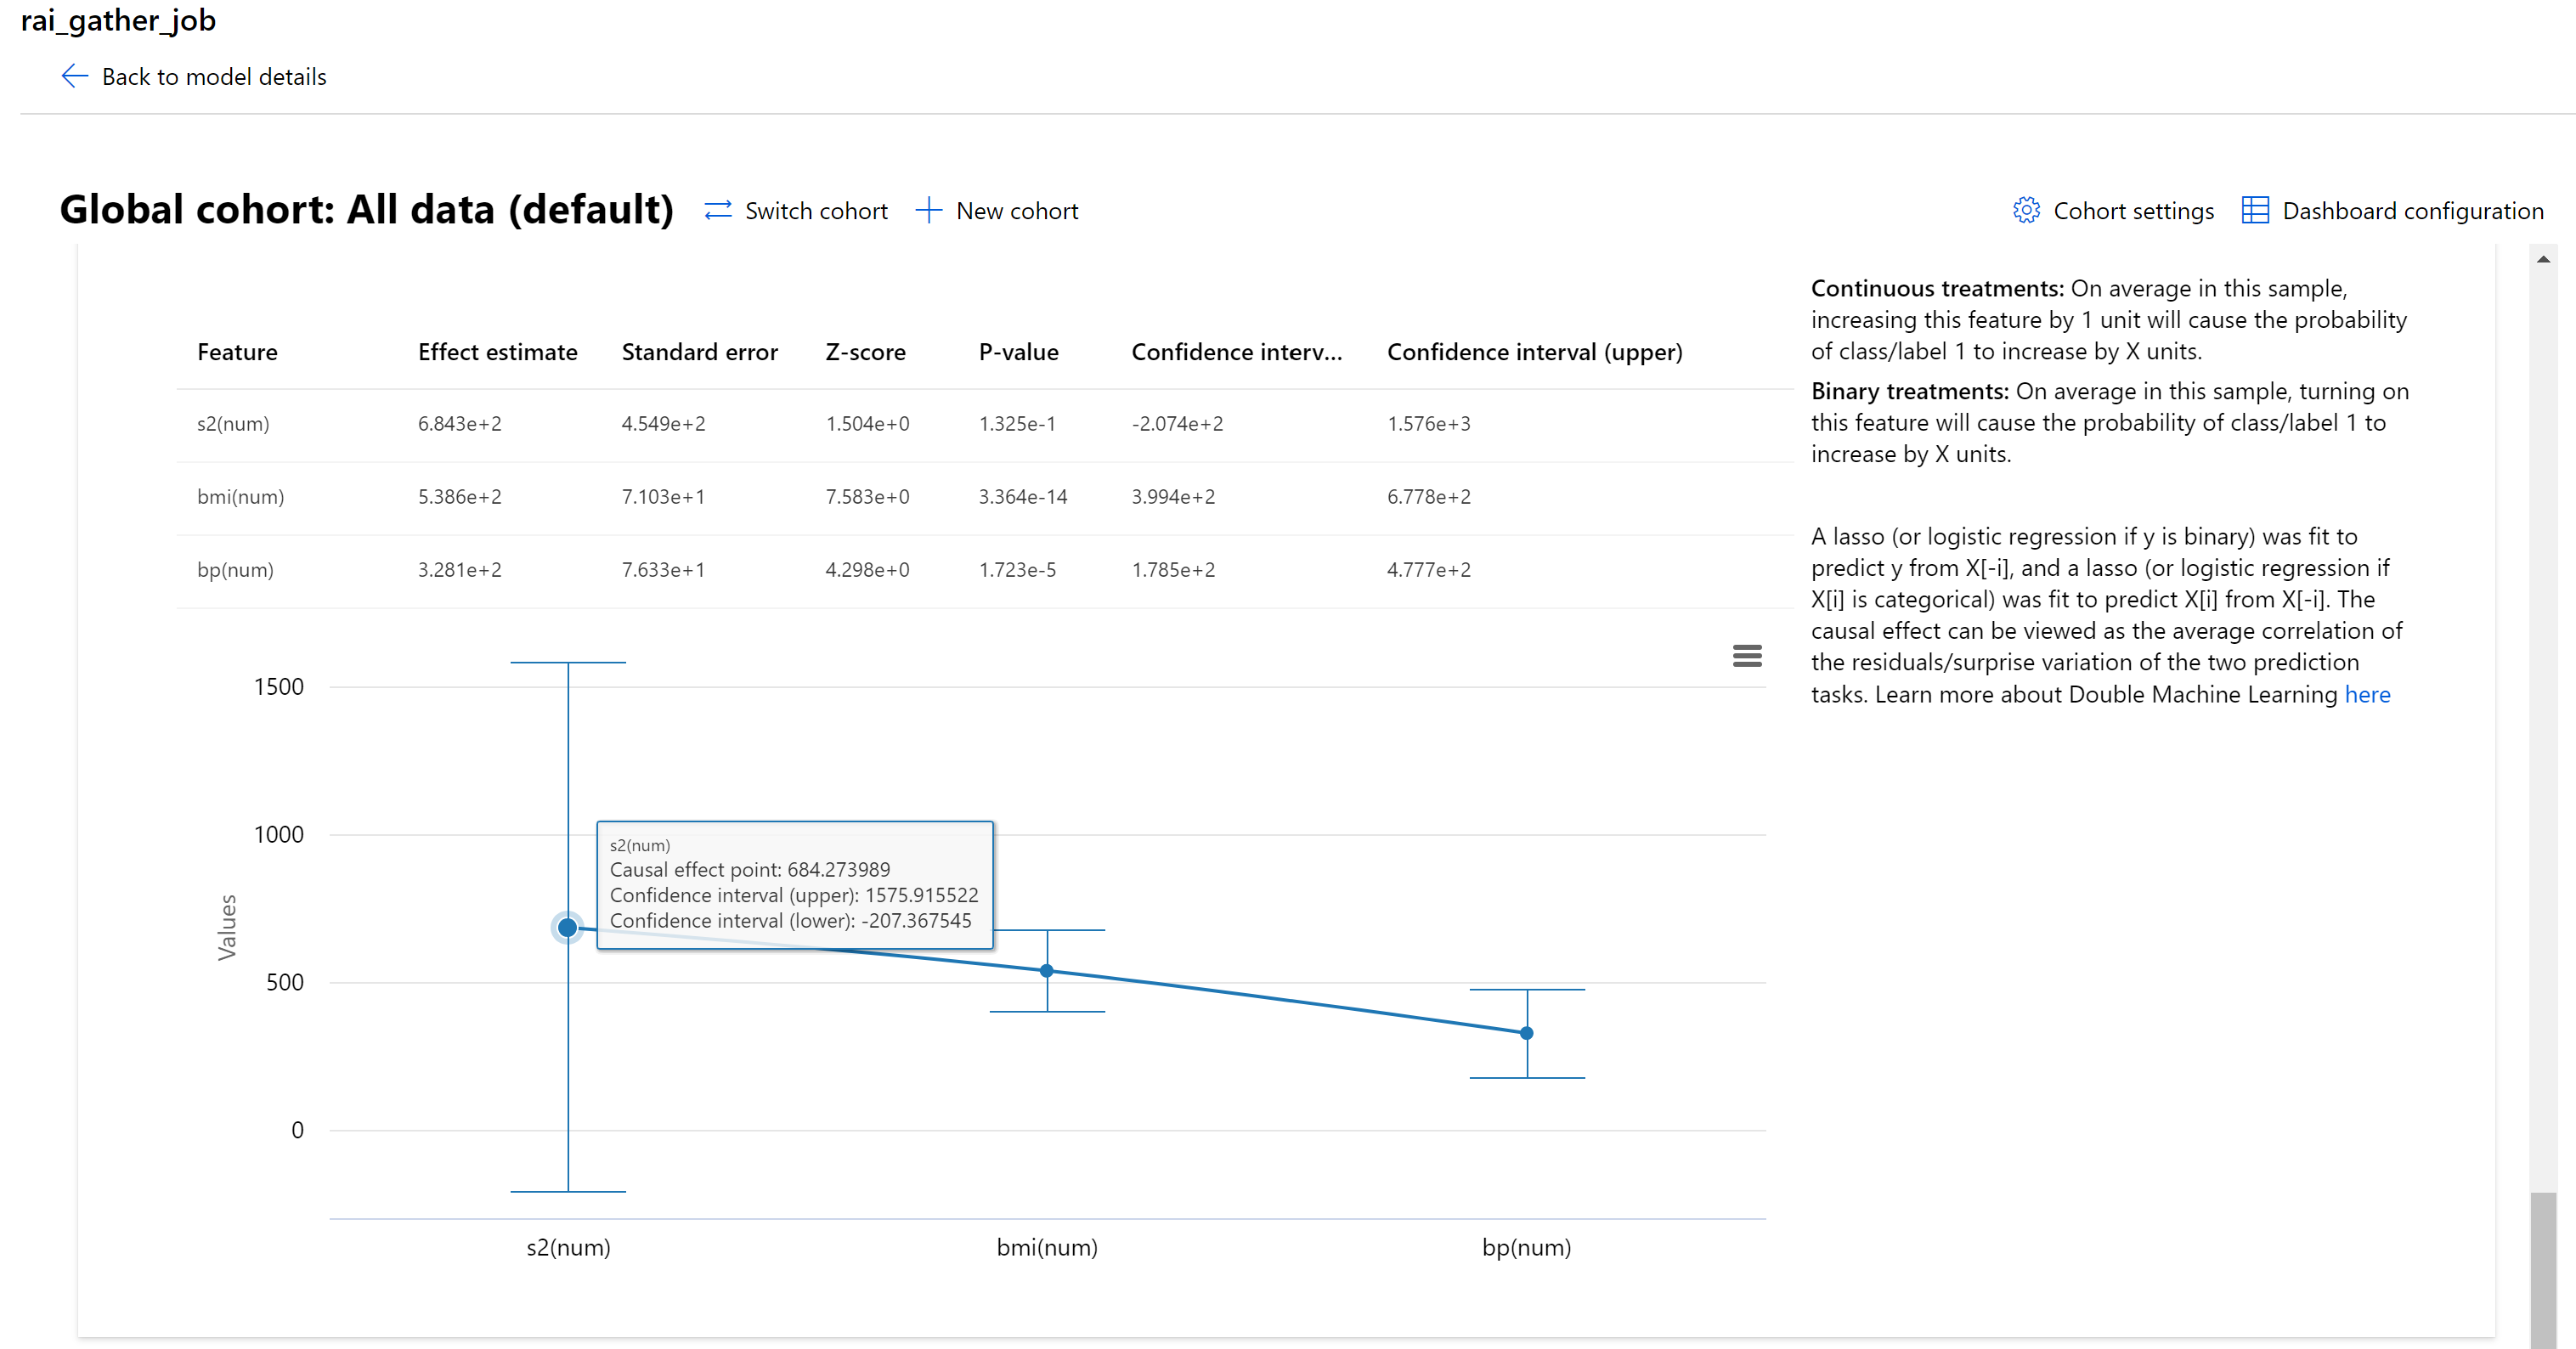